### "A emoção transmitida nas letras influencia a popularidade das músicas?”

Bibliotecas necessárias:

In [ ]:
# Requisitos:
# !pip install spotipy beautifulsoup4 requests unidecode nltk matplotlib wordcloud textblob # descomente se for usar no collab

import requests
from bs4 import BeautifulSoup
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import urllib.parse
import time
import re
import unidecode
import csv
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob  # Simulação local de sentimento
# nltk.download() # d, all                  # da primeira vez que for rodar o código, essa linha deve ser descomentada.
from dotenv import load_dotenv
import os

Configurando API do Spotfy:

In [ ]:
nltk.download('punkt') # modelo de tokenização (divide o texto em palavras e frases).
nltk.download('stopwords') # lista de palavras comuns como “de”, “a”, “o”, que geralmente são removidas no pré-processamento.
nltk.download('omw-1.4')
nltk.download('wordnet')

# Autenticação Spotify
load_dotenv()

SPOTIPY_CLIENT_ID = os.getenv("SPOTIPY_CLIENT_ID")
SPOTIPY_CLIENT_SECRET = os.getenv("SPOTIPY_CLIENT_SECRET")
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET
))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Funções de buscar músicas e raspagem de letras no letras.mus.br

In [10]:
# Limpeza de texto
def limpar_nome(texto):
    texto = texto.lower()
    texto = unidecode.unidecode(texto)
    texto = re.sub(r'\(.*?\)', '', texto)
    texto = re.sub(r'feat\..*', '', texto)
    texto = re.sub(r'remix', '', texto)
    texto = re.sub(r'[^a-z0-9\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

# Coleta: músicas do Spotify
def get_songs_from_artist(artist_name, limit=10):
    results = sp.search(q=f'artist:{artist_name}', type='track', limit=limit)
    songs = []
    for item in results['tracks']['items']:
        songs.append({
            'nome': item['name'],
            'artista': item['artists'][0]['name'],
            'popularidade': item['popularity']
        })
    return songs

# Coleta: letras via scraping
def get_lyrics(song_name, artist_name):
    base_url = 'https://www.letras.mus.br'
    artist = limpar_nome(artist_name).replace(" ", "-")
    song = limpar_nome(song_name).replace(" ", "-")
    url = f"{base_url}/{artist}/{song}/"
    resp = requests.get(url)
    if resp.status_code == 200:
        soup = BeautifulSoup(resp.content, 'html.parser')
        letra_div = soup.find('div', class_='lyric-original')
        if letra_div:
            return letra_div.get_text(separator='\n').strip()
    return None

Pré-processamento

In [11]:
# Pré-processamento para NLP
stop_br = set(stopwords.words('portuguese'))

def preprocessar_texto(texto):
    tokens = word_tokenize(texto.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_br]
    return ' '.join(tokens)

# Classificação de sentimento (simples)
def classificar_sentimento(texto):
    blob = TextBlob(texto)
    pol = blob.sentiment.polarity
    if pol > 0.1:
        return 'positivo'
    elif pol < -0.1:
        return 'negativo'
    return 'neutro'

Executando

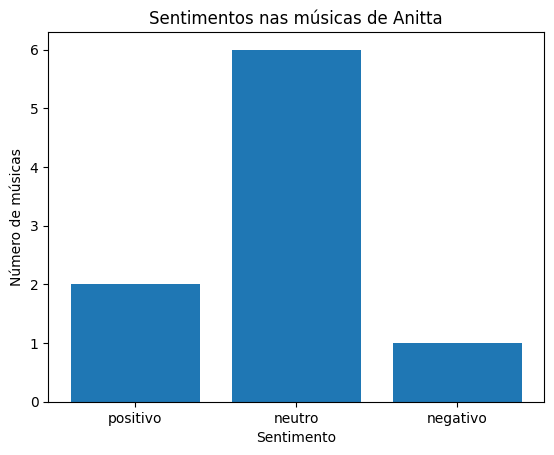

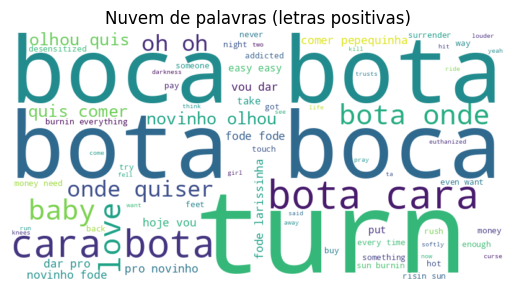

Processo concluído. Arquivo CSV salvo.


In [12]:
# Principal
if __name__ == "__main__":
    artista = "Anitta"
    musicas = get_songs_from_artist(artista, limit=10)

    dataset = []
    for m in musicas:
        letra = get_lyrics(m['nome'], m['artista'])
        if letra:
            texto_limpo = preprocessar_texto(letra)
            sentimento = classificar_sentimento(letra)  # ou texto_limpo
            m.update({'letra': letra, 'sentimento': sentimento, 'letra_limpa': texto_limpo})
            dataset.append(m)
        time.sleep(1)

    # Visualização: gráfico de barras
    sentimentos = [m['sentimento'] for m in dataset]
    contagem = Counter(sentimentos)
    plt.bar(contagem.keys(), contagem.values())
    plt.title("Sentimentos nas músicas de Anitta")
    plt.xlabel("Sentimento")
    plt.ylabel("Número de músicas")
    plt.show()

    # Visualização: nuvem de palavras para letras positivas
    letras_positivas = ' '.join([m['letra_limpa'] for m in dataset if m['sentimento'] == 'positivo'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(letras_positivas)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Nuvem de palavras (letras positivas)")
    plt.show()

    # Exportação opcional
    with open('musicas_anitta.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['nome', 'artista', 'popularidade', 'sentimento', 'letra', 'letra_limpa'])
        writer.writeheader()
        for m in dataset:
            writer.writerow(m)

    print("Processo concluído. Arquivo CSV salvo.")